In [ ]:
#################### biorisk database #######################

In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
# !pip freeze > requirements.lock.txt

In [ ]:
reg_names = pd.read_csv('databases/biorisk/reg_names', index_col=None)
reg_names = reg_names['0'].tolist()

In [ ]:
# filter FASTA files

from Bio import SeqIO
import re

reg_names_covered = []

def sequence_fetcher(file_prefix, reg_names):
    input_file = "databases/biorisk/" + file_prefix + ".fasta"
    output_file = "databases/biorisk/" + file_prefix + "_reg_filt.fasta"
    output_plus_file = "databases/biorisk/" + file_prefix + "_nonreg_filt.fasta"
    fasta = SeqIO.parse(input_file, "fasta")
    records = ()
    records_plus = ()
    for r in fasta:
        regulated = 0
        for tax in reg_names:
            if bool(re.search(tax, r.description)):
#                print("Yes ", tax)
                if regulated == 0:
                    records = records + (r,)
                    reg_names_covered.append(tax)
                    regulated = 1
        if regulated == 0:
            records_plus = records_plus + (r,)
    SeqIO.write(records, output_file, "fasta")
    SeqIO.write(records_plus, output_plus_file, "fasta")


sequence_fetcher("victors_prot", reg_names)
sequence_fetcher("victors_nt", reg_names)

sequence_fetcher("VFDB_setA_pro", reg_names)
sequence_fetcher("VFDB_setA_nt", reg_names)

sequence_fetcher("VFDB_setB_pro", reg_names)
sequence_fetcher("VFDB_setB_nt", reg_names)

sequence_fetcher("blacklist_nt_dedupe", reg_names)


In [ ]:
# process IGSC list

reg_seqs_aus = pd.read_excel("/Users/wheelern/Documents/IGSC_seqs/20160919_GI.xlsx", sheet_name=0)
reg_seqs_eu = pd.read_excel("/Users/wheelern/Documents/IGSC_seqs/20160919_GI.xlsx", sheet_name=1)
reg_seqs_cdc = pd.read_excel("/Users/wheelern/Documents/IGSC_seqs/20160919_GI.xlsx", sheet_name=2)
reg_seqs_usccl = pd.read_excel("/Users/wheelern/Documents/IGSC_seqs/20160919_GI.xlsx", sheet_name=3)
reg_seqs_usitar = pd.read_excel("/Users/wheelern/Documents/IGSC_seqs/20160919_GI.xlsx", sheet_name=4)

output_file = "/Users/wheelern/Documents/IGSC_seqs/reg_seqs.fasta"
if os.path.exists(output_file):
    os.remove(output_file)

f = open(output_file, "a")

def print_seqs(df):
    for i in range(0, reg_seqs_aus.shape[0]):
        reg_names_covered.append(reg_seqs_aus.loc[i,"Organism"])
        f.write(">" + str(reg_seqs_aus.loc[i,"GI"]) + "_" + reg_seqs_aus.loc[i,"Description"] + "\n" + reg_seqs_aus.loc[i,"Sequence"] + "\n")

print_seqs(reg_seqs_aus)
print_seqs(reg_seqs_eu)
print_seqs(reg_seqs_cdc)
print_seqs(reg_seqs_usccl)
print_seqs(reg_seqs_usitar)

f.close()

In [ ]:
# process SeqScreen Blacklist database

from interface.utils import *

for i in range(0, blast.shape[0]):
    hit = 0
    for tax in reg_names:
        if bool(re.search(tax, blast.loc[i,'subject title'])):
#             print(tax)
            reg_names_covered.append(tax)
            hit = 1
    if hit == 0:
        print(blast.loc[i,'subject title'])

# print(blast_trim.head())
# blast_trim['% identity'].hist(bins=50)

KY697335.1    26201
AY504619.1     5949
HM014333.2     3480
CY073798.1     3216
CY069638.1     3182
              ...  
CO020430.1        1
CO020494.1        1
CO020622.1        1
CO020942.1        1
GH433083.1        1
Name: 0, Length: 51599, dtype: int64


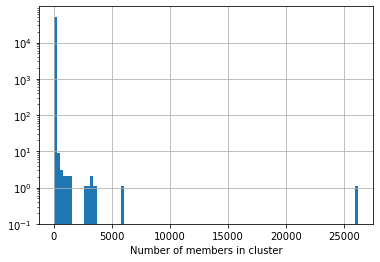

In [16]:
# understanding mmseq clustering 
import matplotlib.pyplot as plt

clusts = pd.read_csv("/Users/wheelern/Documents/IGSC_seqs/biorisk_nt_clust.tsv", sep="\t", header=None)
freqs = clusts[0].value_counts()

fig, ax = plt.subplots()
freqs.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')
ax.set_xlabel("Number of members in cluster")

print(freqs)

In [ ]:
# species coverage in the biorisk database
print(pd.Series(reg_names_covered).value_counts()[0:30])

# species not covered by the biorisk database
print('\n\nSpecies missed')
# for i in set(reg_names):
#     if i not in reg_names_covered:
#         print(i) 

In [ ]:
# look at mapping of biorisk DB to TIGRFAMS (bad)

from Bio import SeqIO
import re
import pandas as pd 

hmmsearch = pd.read_csv('/Users/wheelern/Documents/IGSC_seqs/tigrfamsscan.search.parse', sep="\t", header=None)
queries_covered = hmmsearch[0]
queries_missed = []

input_file = "/Users/wheelern/Documents/IGSC_seqs/reg_seqs.fasta"
fasta = SeqIO.parse(input_file, "fasta")
for r in fasta:
    if r.id not in queries_covered:
        queries_missed.append(r.id)
#         regulated = 0
#         for tax in reg_names:
#             if bool(re.search(tax, r.description)):
# #                print("Yes ", tax)
#                 if regulated == 0:
#                     records = records + (r,)
#                     reg_names_covered.append(tax)
#                     regulated = 1
#         if regulated == 0:
#             records_plus = records_plus + (r,)
#     SeqIO.write(records, output_file, "fasta")
#     SeqIO.write(records_plus, output_plus_file, "fasta")

print(len(queries_missed))
print(len(queries_covered))

In [ ]:
queries_covered

In [ ]:
# mash comparison of biorisks

# this is from the following tutorial: https://sourmash.readthedocs.io/en/latest/kmers-and-minhash.html

def jaccard_similarity(a, b):
    a = set(a)
    b = set(b)

    intersection = len(a.intersection(b))
    union = len(a.union(b))

    return intersection / union

def jaccard_containment(a, b):
    a = set(a)
    b = set(b)

    intersection = len(a.intersection(b))

    return intersection / len(a)

def build_kmers(sequence, ksize):
    kmers = []
    n_kmers = len(sequence) - ksize + 1

    for i in range(n_kmers):
        kmer = sequence[i:i + ksize]
        kmers.append(kmer)

    return kmers

In [ ]:
import screed # a library for reading in FASTA/FASTQ

def read_kmers_from_file(filename, ksize):
    all_kmers = []
    for record in screed.open(filename):
        sequence = record.sequence

        kmers = build_kmers(sequence, ksize)
        all_kmers += kmers

    return all_kmers

reg_kmers = read_kmers_from_file("/Users/wheelern/Documents/IGSC_seqs/reg_seqs_dedupe.fasta", 31)


In [ ]:
from Bio import SeqIO
regseqs = SeqIO.parse("/Users/wheelern/Documents/IGSC_seqs/reg_seqs_dedupe.fasta", "fasta")

kmerslist = []
seqnames = []

for seq in regseqs.records:
    kmerslist.append(build_kmers(seq.seq, 31))
    seqnames.append(seq.id)
    

In [46]:
fasta = pd.read_csv("/Users/wheelern/Documents/IGSC_seqs/reg_seqs_dedupe.fasta", sep="\t", header=None)
indices = []
count = 0

for line in range(fasta.shape[0]):
    if re.search(">", fasta[0][line]):
        name = re.sub(">", "", fasta[0][line])
        indices.append(name)


In [101]:
import pandas as pd
import re
from collections import defaultdict

reference = ""
dist_dic = defaultdict(list)
index_dic = defaultdict(list)
count = 0

dists = pd.read_csv("/Users/wheelern/Documents/IGSC_sequences/biorisk_cobs_dist", sep="\t", header=None)
for line in range(dists.shape[0]):
    if re.search("\*", dists[0][line]):
        reference = dists[0][line]
        index_dic[re.sub("\*", "", reference)] = count
        count+=1    
    else:
        seq_index = int(re.sub("reg_seqs_dedupe_", "", dists[0][line]))
        seq_name = indices[seq_index]
        dist_dic[reference].append([seq_name, dists[1][line]])



In [95]:
dist_dic['*1617008_abrin']

[['1617008_abrin A chain (E164A), partial [Abrus precatorius]', 221, 1.0],
 ['1617006_abrin A chain E164A/R167L, partial [Abrus precatorius]', 200, 0.9],
 ['16091_ricin A-chain type 73, partial [Abrus precatorius]', 199, 0.9],
 ['999849_A Chain A, Crystal Structure Of Abrin-A', 199, 0.9],
 ['1617004_abrin A-chain, partial [Abrus precatorius]', 199, 0.9],
 ['166295_abrin-a, partial [Abrus precatorius]', 197, 0.89],
 ['543748_ABRA_ABRPR RecName: Full=Abrin-a; Contains: RecName: Full=Abrin-a A chain; AltName: Full=rRNA N-glycosidase; Contains: RecName: Full=Linker peptide; Contains: RecName: Full=Abrin-a B chain; Flags: Precursor',
  196,
  0.89],
 ['226012_1406189A abrin a A', 177, 0.8]]

Text(0.5, 0, 'Number of members in cluster')

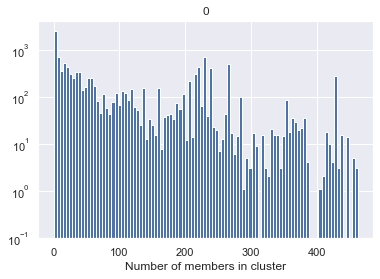

In [79]:
# cobs cluster size distribution
import matplotlib.pyplot as plt

c_sizes = []

for i in dist_dic.keys():
    c_sizes.append(len(dist_dic[i]))

fig, ax = plt.subplots()
pd.DataFrame(c_sizes).hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')
ax.set_xlabel("Number of members in cluster")


In [109]:
# COBS PID reporting
# could compare PIDs from mmseqs-2 and COBS - just compare some matching keys. Use of different index sequences will make this harder

for key in dist_dic.keys():
    ref_kmers = 0
    for entry in dist_dic[key]:
        if re.sub(" .*", "", entry[0]) == re.sub("\*", "", key):
            ref_kmers = entry[1]
    for entry in dist_dic[key]:
        entry.append(round(entry[1]/ref_kmers, 2))


In [122]:
import numpy as np
from scipy.sparse import dok_matrix

M = dok_matrix((len(indices), len(indices)))

for key in dist_dic.keys():
    for entry in dist_dic[key]:
        M[index_dic[re.sub("\*", "", key)], index_dic[re.sub(" .*", "", entry[0])]] = entry[2]

In [124]:
print(len(dist_dic.keys()))

1 - M[:10,:10].todense()


12711


matrix([[0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [1.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [1.  , 1.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [1.  , 1.  , 1.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [1.  , 1.  , 1.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 1.  , 1.  , 1.  , 0.08],
        [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 1.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 1.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 1.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  , 0.07, 1.  , 1.  , 1.  , 0.  ]])

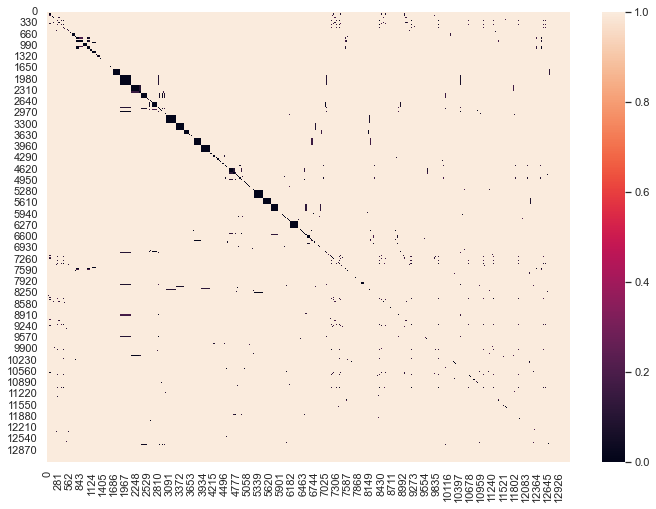

In [125]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

fig_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=fig_dims)

# ax = sns.heatmap(M.todense()[:10,:10])
ax = sns.heatmap(1-M.todense())

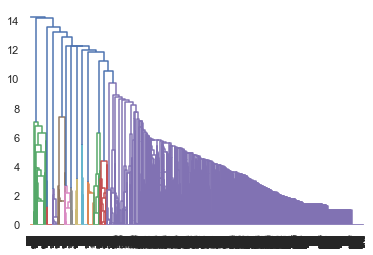

In [126]:
from scipy.cluster import hierarchy

mat = 1-M.todense()



In [129]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth

mat = 1-M.todense()

bandwidth = estimate_bandwidth(mat, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(mat)
labels = ms.labels_


ValueError: No point was within bandwidth=7.652146 of any seed. Try a different seeding strategy                              or increase the bandwidth.

In [128]:
!pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 7.2 MB 4.4 MB/s eta 0:00:01
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=5fa507734b2c264c6e65df0e9e79247b2c7f6b096b525202dfee231cf7898c49
  Stored in directory: /Users/wheelern/Library/Caches/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [57]:
index_dic[key]
key

'*155315_zonula occludens toxin [Vibrio cholerae]'

In [ ]:
# understanding mmseq clustering 
import matplotlib.pyplot as plt

clusts = pd.read_csv("/Users/wheelern/Documents/IGSC_seqs/biorisk_nt_clust.tsv", sep="\t", header=None)
freqs = clusts[0].value_counts()

fig, ax = plt.subplots()
freqs.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')
ax.set_xlabel("Number of members in cluster")

print(freqs)

In [ ]:
clusts = pd.read_csv("/Users/wheelern/Documents/IGSC_seqs/biorisk_nt_clust.tsv", sep="\t", header=None)
